Задание к домашней работе  
Теперь решаем задачу регрессии - предскажем цены на недвижимость.  
- Использовать датасет www.kaggle.com...iques/data (train.csv)  
- Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей  
- Построить случайный лес, вывести важность признаков  
- Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную  
- Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии  
- Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)  
В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, cross_val_predict

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')
#data.info(); data.head()

In [3]:
#data.describe().T

In [4]:
#допущения: будем использовать только непрерывные признаки, пустые значения заполним "0"
X = data.drop('SalePrice', axis=1).select_dtypes(include=[np.number]).fillna(0)
Y = data['SalePrice']
#строим лес
X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, test_size = 0.20, shuffle = True, random_state = 42)
rfr = RandomForestRegressor(random_state = 42).fit(X_tr, Y_tr)
print(f'R^2: {r2_score(Y_t, rfr.predict(X_t))}')

R^2: 0.885680420864081


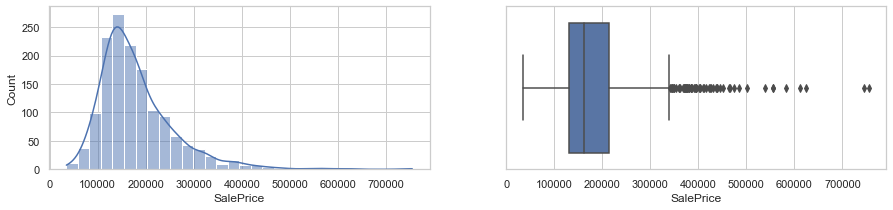

In [5]:
#проанализируем целевую переменную
plt.figure(figsize=(15, 3)); sns.set_theme(style = "whitegrid")
#распределение переменных
plt.subplot(1, 2, 1); sns.histplot(x = Y, kde = True, bins = 30)
#боксплот
plt.subplot(1, 2, 2); sns.boxplot(x = Y)
plt.show()

In [6]:
#попробуем выделить недвижимость класса LUX
X['LUX'] = [1 if x > 305000 else 0 for x in data['SalePrice']]
X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)
rfr = RandomForestRegressor(random_state = 42).fit(X_tr, Y_tr)
print(f'R^2: {r2_score(Y_t, rfr.predict(X_t))}')

R^2: 0.910703604797158


In [7]:
#стало чуть-чуть получше

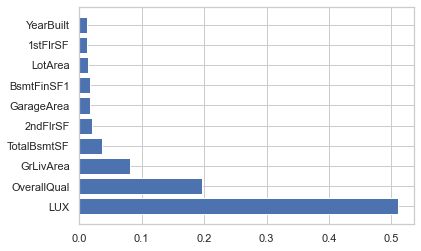

In [8]:
#получим важность признаков, выберем 10 лучших
n_best = 10
imp_sort = []
feature_sort = []

col_imp = [[X.columns[i], rfr.feature_importances_[i]] for i in range(0, len(X.columns))]
col_imp.sort(key = lambda x: x[1], reverse = True)
for item in col_imp[:n_best]:
    imp_sort.append(item[1]); feature_sort.append(item[0])

plt.barh(np.arange(n_best), imp_sort)
plt.yticks(np.arange(n_best), feature_sort)
plt.show()

In [9]:
#стекинг
#в качестве датасета для кросс-валидации базовых моделей будем использовать [X_tr, Y_tr],
#а в качетсве hold-out датасета для тестирования метамодели будем использовать [X_t, Y_t], полученные на шаге
#X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)

In [10]:
#этап №1 - получение метапризнаков (предсказаний обученных с использованием кросс-валидации базовых моделей)
#строим стек базовых моделей

models = [LinearRegression(), \
          DecisionTreeRegressor(), \
          Ridge(), \
          Lasso(), \
          ElasticNet()]

#обучаем и фиксируем предсказания базовых моделей на тренировочном датасете
k_fold = 10
r2_scores = {}
#это матрица для фиксации предсказаний базовых моделей
meta_train = np.zeros((Y_tr.shape[0], len(models)))
#обучение базовых моделей на трейне
for item, model in enumerate(models):
    #проводим обучение модели используя кросс-валидацию на k_fold наборах и фиксируем предсказание 
    #(будущие метапризнаки)
    meta_train[:, item] = cross_val_predict(estimator = model, X = X_tr, y = Y_tr, \
                                            cv = k_fold, method='predict')
    #фиксируем значение R^2 предсказания, на всякий случай
    r2_scores[model] = round(r2_score(Y_tr, meta_train[:, item]), 4)
    #настраиваем модель
    model.fit(X_tr, Y_tr)
    
#обучение метемодели на метапризнаках тренировочного датасета
r = Ridge()
r.fit(meta_train, Y_tr)

Ridge()

In [11]:
#этап №2 - получение предсказаний (метепризнаков) обученных базовых моделей на тестовом (hold-out) датасете
#и получение предсказания метамодели на этих метапризнаках

#матрица для метапризнаков из предсказаний базовых моделей для тестового датасета
meta_test = np.zeros((Y_t.shape[0], len(models)))
#получение предсказания базовых моделей на тесте
for item, model in enumerate(models):
    meta_test[:, item] = model.predict(X_t)

#получение предсказания метамодели
predicts = r.predict(meta_test)

#считаем коэффициент детерминации
print(r2_score(Y_t, predicts))

0.8908154976562025


In [12]:
#стекинг получился чуть хуже случайного леса - но, лес это же тоже ансамбль :))
#сравним с НЕ ансамблиевыми методами

In [13]:
print(r2_scores)

{LinearRegression(): 0.845, DecisionTreeRegressor(): 0.7875, Ridge(): 0.8447, Lasso(): 0.845, ElasticNet(): 0.7567}


In [14]:
#у всех протестированных НЕ ансамблевых моделей коэффициент детерминации хуже, чем в случае применения 
#стекинга моделей

In [15]:
#Вывод: стекинг лучше